In [1]:
#import the necessities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from scipy.stats import bartlett, levene
from sklearn import linear_model
from sqlalchemy import create_engine
from statsmodels.tsa.stattools import acf
warnings.filterwarnings('ignore')

In [63]:
#create the authorization variables
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
weather_db = 'weatherinszeged'
houses_db = 'houseprices'

In [70]:
#connect and dispose of engine
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, weather_db))

weather_df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

engine.dispose()

In [67]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, houses_db))

houseprices_df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [4]:
#confirm the df and check the stats
display(weather_df.head())
print(weather_df.shape)
print(weather_df.info())

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


(96453, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: dat

In [68]:
#confirm the second df and check the stats
display(houseprices_df.head())
print(houseprices_df.shape)
print(houseprices_df.info())

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 1

In [71]:
#I always prefer to make a clean copy of the df to
#prevent having to connect with the database
copy_weather_df = weather_df.copy()
copy_houseprices_df = houseprices_df.copy()

In [72]:
#temperature is the target variable with humidity, windspeed,
#windbearing, and pressure as the explanatory variables
weather_y = weather_df['temperature']
weather_X = weather_df[['humidity', 'pressure', 'windbearing', 'windspeed']]

In [73]:
#build the linear regression model
weather_lrm = linear_model.LinearRegression()
#fit it using OLS
weather_lrm.fit(weather_X, weather_y)
#prediction of the linear regression
weather_predictions = lrm.predict(weather_X)
print('Coefficients: ', lrm.coef_)
print('\nIntercept:', lrm.intercept_)

Coefficients:  [-3.24962454e+01 -6.91759209e-04  4.04836936e-03 -2.01413742e-01]

Intercept: 37.92643818528534


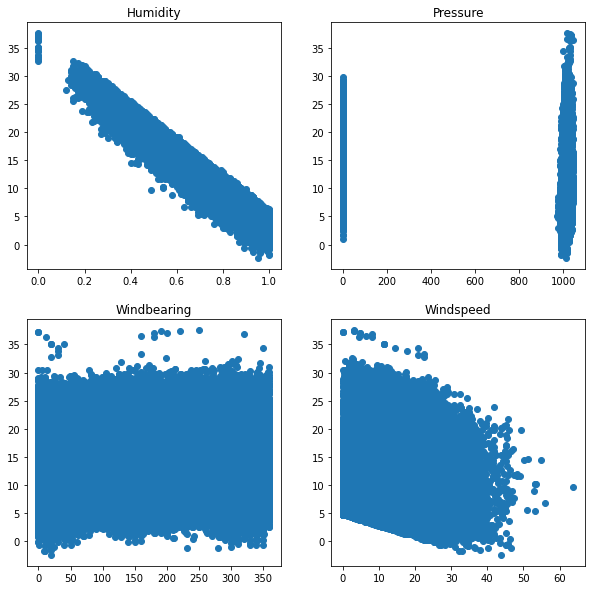

In [74]:
#checking assumption 1: linear of the model in its coefficients
#plot estimated target and actual
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.scatter(weather_X['humidity'], weather_predictions)
plt.title('Humidity')
plt.subplot(2, 2, 2)
plt.scatter(weather_X['pressure'], weather_predictions)
plt.title('Pressure')
plt.subplot(2, 2, 3)
plt.scatter(weather_X['windbearing'], weather_predictions)
plt.title('Windbearing')
plt.subplot(2, 2, 4)
plt.scatter(weather_X['windspeed'], weather_predictions)
plt.title('Windspeed')
plt.show()
##humidity shows a but of linearity but the others do not

In [75]:
#checking assumption 2: the error term's expected value
weather_errors = weather_y - weather_predictions
print('Mean of the errors in the weather prediction is', np.mean(errors))
#that low of a value is basically negligible

Mean of the errors in the weather prediction is -8.615827004194611e-15


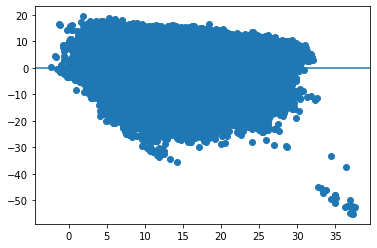

In [76]:
#checking assumption 3: homoscedasticity
plt.scatter(weather_predictions, weather_errors)
plt.axhline(y=0)
plt.show()

In [77]:
#checking the homoscedasticity statistically
weather_bart_stats = bartlett(weather_predictions, weather_errors)
weather_lev_stats = levene(weather_predictions, weather_errors)
print("Bartlett test statistic value is {0:3g} and p value is {1:3g}".format(bart_stats[0],bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:3g}".format(lev_stats[0],lev_stats[1]))
#we reject the null and state these are heteroscedastic

Bartlett test statistic value is 2464.84 and p value is   0
Levene test statistic value is 2321.24 and p value is   0


In [78]:
#checking assumption 4: low multicollinearity
display(weather_X.corr())
#no collinearity that we can find

,humidity,pressure,windbearing,windspeed
humidity,1.000000,0.005454,0.000735,-0.224951
pressure,0.005454,1.000000,-0.011651,-0.049263
windbearing,0.000735,-0.011651,1.000000,0.103822
windspeed,-0.224951,-0.049263,0.103822,1.000000


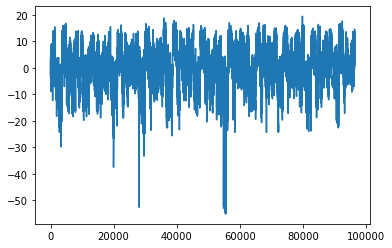

In [79]:
#testing assumption 5: uncorrelated error terms
plt.plot(weather_errors)
plt.show()

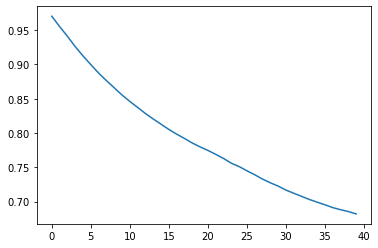

In [80]:
#checking using the autocorrelation function
weather_acf_data = acf(weather_errors)
plt.plot(weather_acf_data[1:])
plt.show()
#looks high at ~0.98 to ~0.70

In [81]:
#checking assumption 6: independence of the features and errors
weather_X_error = weather_X.merge(errors, left_index=True, right_index=True)
display(weather_X_error.corr())
#low enough to be negligible

,humidity,pressure,windbearing,windspeed,temperature
humidity,1.000000e+00,5.454263e-03,7.346454e-04,-2.249515e-01,2.964392e-16
pressure,5.454263e-03,1.000000e+00,-1.165088e-02,-4.926281e-02,-1.747844e-15
windbearing,7.346454e-04,-1.165088e-02,1.000000e+00,1.038215e-01,-1.195108e-16
windspeed,-2.249515e-01,-4.926281e-02,1.038215e-01,1.000000e+00,3.483848e-16
temperature,2.964392e-16,-1.747844e-15,-1.195108e-16,3.483848e-16,1.000000e+00


Assumption 1: the graphs don't show linearity. Adding a constant would fix this issue.
Assumption 2: the error was essentially zero.
Assumption 3: the model is heteroscedastic. Checking / fixing outliers or adding more variables could alleviate this. If this is not corrected, this could lead to overconfidence in the model.
Assumption 4: all variables have a low correlation with each other
Assumption 5: errors and features seem highly correlated. Adding a needed variable can potentially fix this. If this is not corrected, the model may be missing needed data.
Assumption 6: there is no correlation between the features and errors.

In [57]:
#now onto the houseprices data that we used last module

[ 6.47479331  7.4525369   8.3366275  ... 17.33793889 15.68609968
 16.37506898]


In [83]:
#create the variables needed
#previously used variables were lotarea, overallqual, overallcond, centralair 
houseprices_y = houseprices_df['saleprice']
dummy_df = pd.get_dummies(houseprices_df['centralair'], drop_first=True)
houseprices_X = houseprices_df[['lotarea', 'overallqual', 'overallcond']].merge(
    dummy_df, left_index=True, right_index=True)

In [87]:
#run the linear regression, create the prediction and the error
houses_lrm = linear_model.LinearRegression()
houses_lrm.fit(houseprices_X, houseprices_y)
houses_predictions = houses_lrm.predict(houseprices_X)
houseprices_errors = houseprices_y - houses_predictions
print("Coefficient:", houses_lrm.coef_)
print("\nIntercept:", houses_lrm.intercept_)

Coefficient: [ 1.44427895e+00  4.37002906e+04 -8.03690365e+02  1.18104351e+04]

Intercept: -107370.97718358747


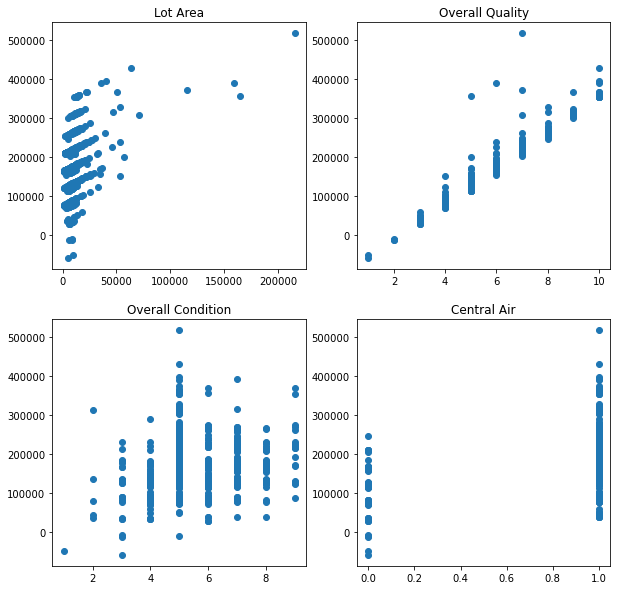

In [88]:
#checking assumption 1: linear of the model in its coefficients
#plot estimated target and actual
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.scatter(houseprices_X['lotarea'], houses_predictions)
plt.title('Lot Area')
plt.subplot(2, 2, 2)
plt.scatter(houseprices_X['overallqual'], houses_predictions)
plt.title('Overall Quality')
plt.subplot(2, 2, 3)
plt.scatter(houseprices_X['overallcond'], houses_predictions)
plt.title('Overall Condition')
plt.subplot(2, 2, 4)
plt.scatter(houseprices_X['Y'], houses_predictions)
plt.title('Central Air')
plt.show()
#overallqual has a bit of linearity

In [89]:
#checking assumption 2: the error term's expected value
print('Mean of the errors in the houseprices model is', np.mean(houseprices_errors))
#low enough that it is essentially zero

Mean of the errors in the houseprices model is -2.372161523528295e-12


In [90]:
#checking assumption 3: homoscedasticity
houses_bart_stats = bartlett(houses_predictions, houseprices_errors)
houses_lev_stats = levene(houses_predictions, houseprices_errors)
print("Bartlett test statistic value is {0:3g} and p value is {1:3g}".format(houses_bart_stats[0],houses_bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:3g}".format(houses_lev_stats[0],houses_lev_stats[1]))
#low p value means the data is heteroscedasticity

Bartlett test statistic value is 156.995 and p value is 5.1322e-36
Levene test statistic value is 178.563 and p value is 1.4196e-39


In [91]:
#checking assumption 4: low multicollinearity
display(houseprices_X.corr())
#low correlations for the values

,lotarea,overallqual,overallcond,Y
lotarea,1.000000,0.105806,-0.005636,0.049755
overallqual,0.105806,1.000000,-0.091932,0.272038
overallcond,-0.005636,-0.091932,1.000000,0.118969
Y,0.049755,0.272038,0.118969,1.000000


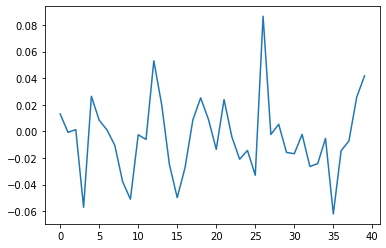

In [92]:
#checking assumption 5: uncorrelated error terms
houses_acf_data = acf(houseprices_errors)
plt.plot(houses_acf_data[1:])
plt.show()
#-0.06 to 0.08 is very low

In [93]:
#checking assumption 6: independence of the features and errors
houseprices_X_errors = houseprices_X.merge(houseprices_errors, left_index=True, right_index=True)
display(houseprices_X_errors.corr())
#negligibly zero values are better

,lotarea,overallqual,overallcond,Y,saleprice
lotarea,1.000000e+00,1.058057e-01,-5.636270e-03,4.975494e-02,-3.627882e-16
overallqual,1.058057e-01,1.000000e+00,-9.193234e-02,2.720384e-01,-3.363815e-16
overallcond,-5.636270e-03,-9.193234e-02,1.000000e+00,1.189694e-01,4.291305e-18
Y,4.975494e-02,2.720384e-01,1.189694e-01,1.000000e+00,-1.121062e-17
saleprice,-3.627882e-16,-3.363815e-16,4.291305e-18,-1.121062e-17,1.000000e+00


Assumption 1: the graphs don't show linearity. Adding a constant would fix this issue.
Assumption 2: the error was essentially zero.
Assumption 3: the model is heteroscedastic. Checking / fixing outliers or adding more variables could alleviate this. If this is not corrected, this could lead to overconfidence in the model.
Assumption 4: all variables have a low correlation with each other
Assumption 5: errors and features seem uncorrelated.
Assumption 6: there is no correlation between the features and errors.